# Task 1. Experimental time complexity analysis

**Goal** \
Experimental study of the time complexity of different algorithms

**Problems and methods** \
For each n from 1 to 2000, measure the average computer execution time (using timestamps) of programs implementing the algorithms and functions below for five runs. Plot the data obtained showing the average execution time as a function of n. Conduct the theoretical analysis of the time complexity of the algorithms in question and compare the empirical and theoretical time complexities.

In [416]:
import time
from random import randint
from typing import List, Callable, Any, Tuple, TypeVar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.optimize import curve_fit
import sorting 


plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['lines.markersize'] = 0.7

In [417]:
N = 2000 # input size
K = 5 # repeat times
M = 10 # batch size

NN = 200 # shorten input size for polynom and matfix
NNN = 500 # shorten input size for sorting

T = TypeVar('T')

## Util functions to run the experiment

In [418]:
def run(inputs_block: List[T], f: Callable[[T], Any], metrics: Callable[[], Any]) -> float:
    start = metrics()
    for input in inputs_block:
        for _ in range(K):
            f(input)
    end = metrics()
    return (end - start) / len(inputs_block) / REPEAT_TIMES

In [419]:
def run_experiment(inputs: List[List[T]], f: Callable[[T], Any], metrics: Callable[[], Any]=time.perf_counter_ns) -> List[float]:
    experiment_result = []
    for inputs_block in inputs:
        experiment_metrics = run(inputs_block, f, metrics)
        experiment_result.append(experiment_metrics)
    return experiment_result

In [420]:
def get_polynom_coeffs(inputs_size: List[int], empirical_result: List[float], degree: int, remove_outliers=True):
    if remove_outliers:
        elements = np.array(empirical_result)
        is_inlier = np.abs(stats.zscore(elements)) < 1.3
        empirical_result = [x for i, x in enumerate(empirical_result) if is_inlier[i]]
        inputs_size = [x for i, x in enumerate(inputs_size) if is_inlier[i]]
    
    coeffs = np.polyfit(inputs_size, empirical_result, degree)
    return coeffs

In [421]:
def nlogn(x, a, b, c):
    return a * x * np.log(x) + b * x + c

def get_nlogn_coeffs(inputs_size: List[int], empirical_result: List[float], remove_outliers=False):
    if remove_outliers:
        elements = np.array(empirical_result)
        is_inlier = np.abs(stats.zscore(elements)) < 1.3
        empirical_result = [x for i, x in enumerate(empirical_result) if is_inlier[i]]
        inputs_size = [x for i, x in enumerate(inputs_size) if is_inlier[i]]
    
    coeffs, _ = curve_fit(nlogn, inputs_size, empirical_result)
    return coeffs

In [422]:
def run_theoretical(inputs_size: List[int], empirical_result: List[float], f_type: str='poly', degree: int=None, coeffs: List[float]=None) -> List[float]:        
    if coeffs is None:
        if f_type == 'poly':
            coeffs = get_polynom_coeffs(inputs_size, empirical_result, degree)
        if f_type == 'nlogn':  
            coeffs = get_nlogn_coeffs(inputs_size, empirical_result)
        print(f"using proposed coeffs", coeffs)
    else:
        print(f"using given coeffs", coeffs)
    
    if f_type == 'poly':
        p = np.poly1d(coeffs)
    if f_type == 'nlogn':
        p = lambda x: nlogn(np.array(x), coeffs[0], coeffs[1], coeffs[2])

    mse = mean_squared_error(empirical_result, p(inputs_size))
    print(f"MSE={mse}")
    rmse = mean_squared_error(empirical_result, p(inputs_size), squared=False)
    print(f"RMSE={rmse}")
        
    theoretical_result = [p(input_size) for input_size in inputs_size]
    return theoretical_result

In [423]:
def visualize(inputs_size: List[int], empirical_result: List[float], theoretical_result: List[float] = None, title: str = ""):
    plt.plot(inputs_size, empirical_result, 'o', color='blue', label="Empirical Runtime")
    if theoretical_result is not None:
        plt.plot(inputs_size, theoretical_result, color='red', label="Theoretical Runtime")
    plt.xlabel("Input Size", fontsize=20)
    plt.ylabel("Mean Runtime [ns]", fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

# Experiment №1 
Generate N input vectors of size 1 to N of integers in range [1 ... MAX_VALUE] 

In [424]:
inputs_size = [n for n in range(1, N)]
inputs = [np.random.rand(M, n) for n in inputs_size]

In [425]:
total_results = []

## 1. Constant function

using proposed coeffs [79.14678535]
MSE=2383.3361152661123
RMSE=48.81942354500012


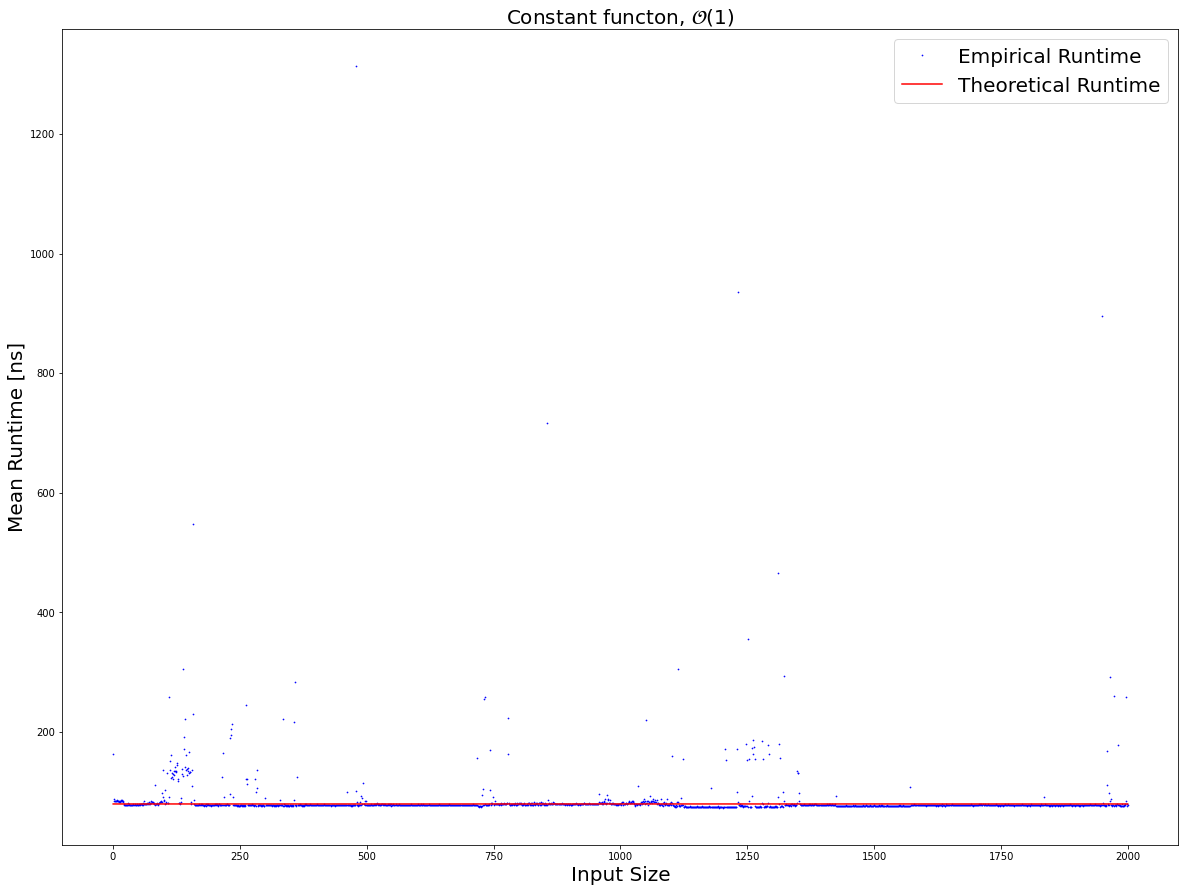

In [426]:
def calc_const(input: List[float]) -> int:
    return sum(range(10))

empirical_result = run_experiment(inputs, calc_const)
theoretical_result = run_theoretical(inputs_size, empirical_result, f_type='poly', degree=0)
visualize(inputs_size, empirical_result, theoretical_result, r'Constant functon, $\mathcal{O}(1)$')

total_results.append((empirical_result, theoretical_result))

##  2. Sum of elements

using proposed coeffs [ 18.752798  192.9142115]
MSE=1870225.3630014088
RMSE=1367.5618315094234


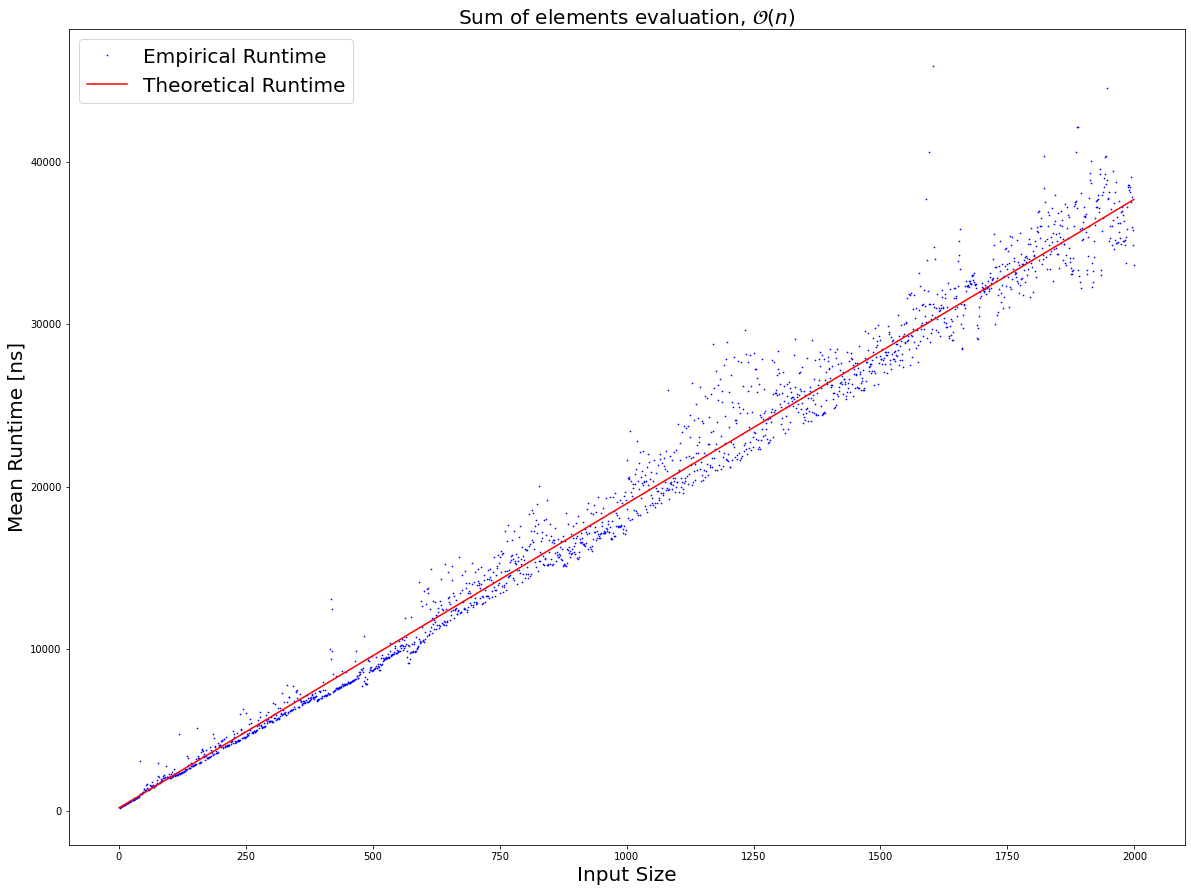

In [427]:
def calc_sum(input: List[float]) -> float:
    s = 0
    for x in input:
        s += x
    return s

empirical_result = run_experiment(inputs, calc_sum, time.perf_counter_ns)
theoretical_result = run_theoretical(inputs_size, empirical_result, f_type='poly', degree=1)
visualize(inputs_size, empirical_result, theoretical_result, r'Sum of elements evaluation, $\mathcal{O}(n)$')

total_results.append((empirical_result, theoretical_result))

##  3. Product of elements

using proposed coeffs [  22.476023   -362.66225253]
MSE=5307413.029343391
RMSE=2303.7823311553093


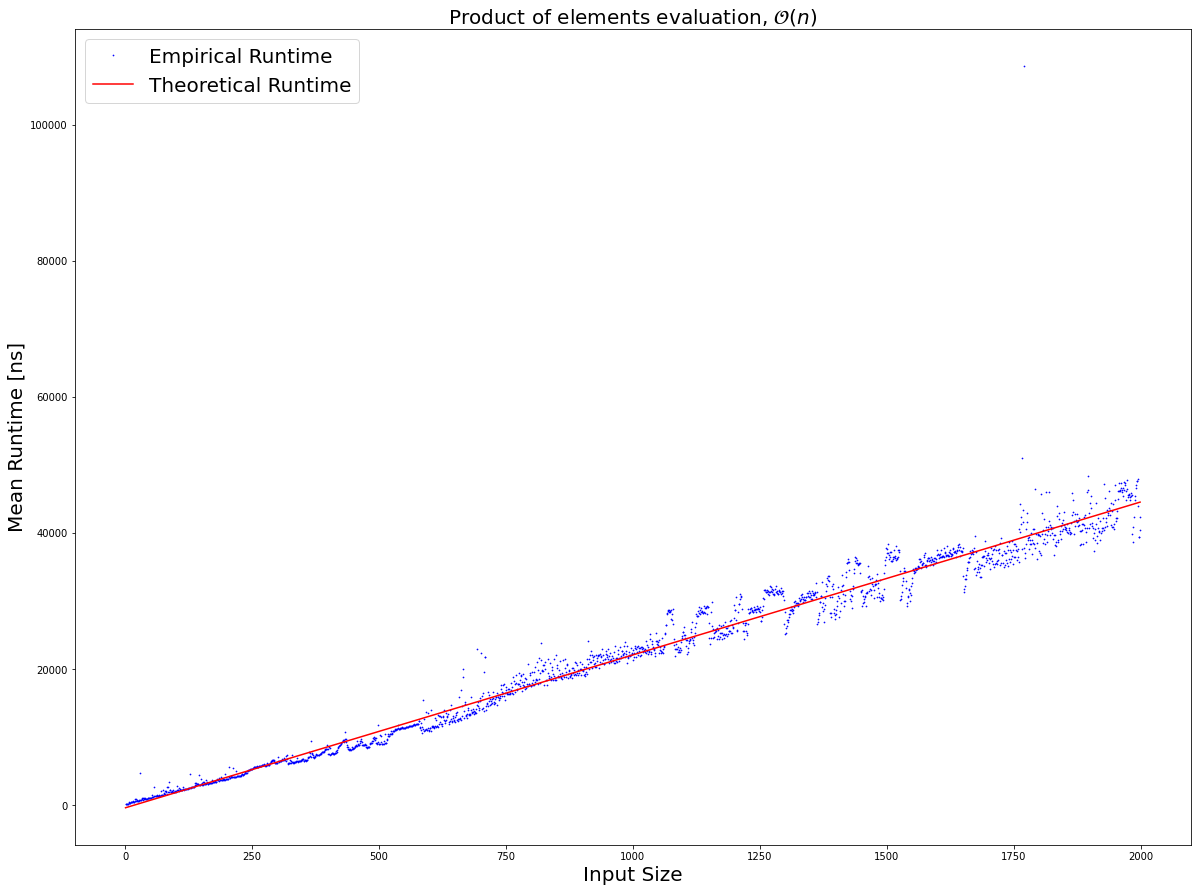

In [428]:
def calc_prod(input: List[float]) -> int:
    p = 1.0
    for x in input:
        p *= x
    return p

empirical_result = run_experiment(inputs, calc_prod)
theoretical_result = run_theoretical(inputs_size, empirical_result, f_type='poly', degree=1)
visualize(inputs_size, empirical_result, theoretical_result, r'Product of elements evaluation, $\mathcal{O}(n)$')

total_results.append((empirical_result, theoretical_result))

##  4. Polynomial function calculation

In [429]:
s_inputs_size = inputs_size[:NN]
s_inputs = inputs[:NN]

using proposed coeffs [  3.31887158  97.20301497 916.10610526]
MSE=27483286.194267493
RMSE=5242.450399790874


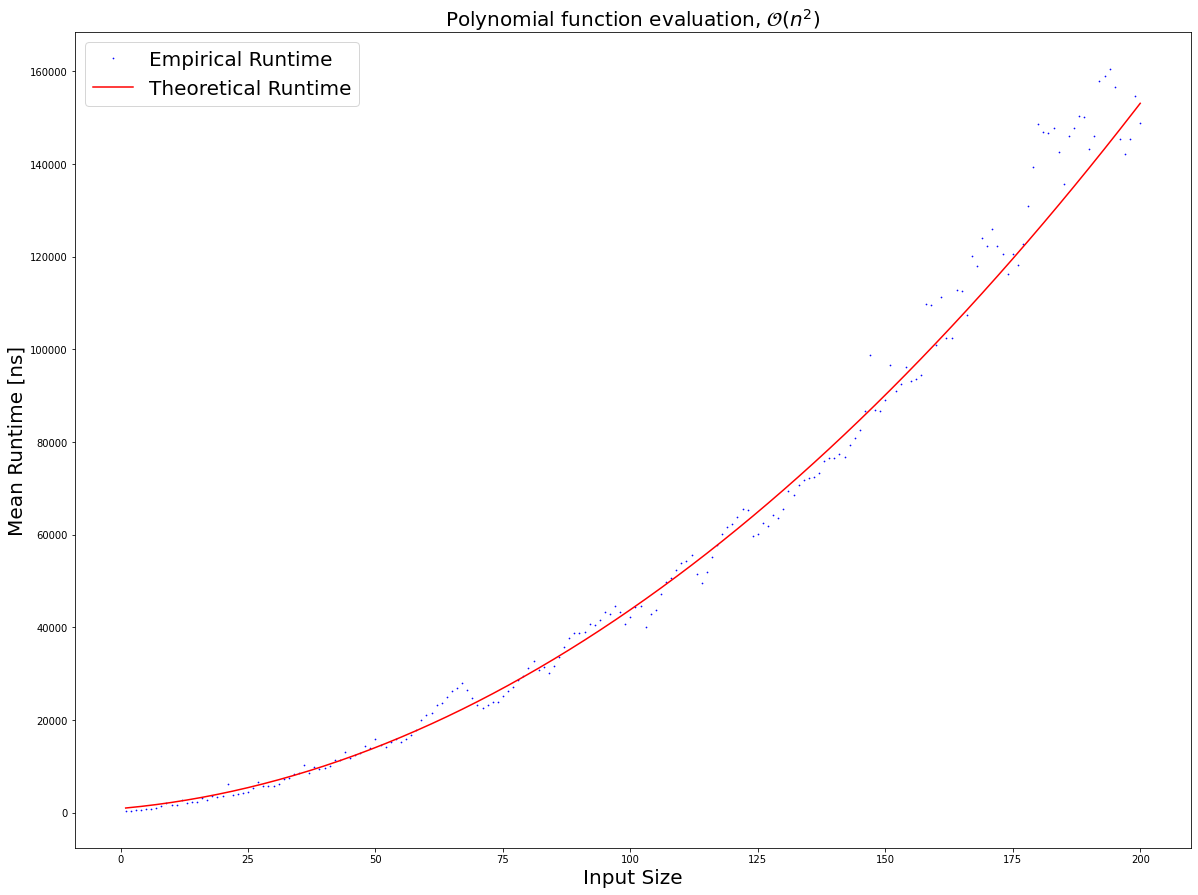

In [430]:
def calc_poly(input: List[float], v=1.5) -> int:
    p = 0
    for i, x in enumerate(input):
        pow_v = 1
        for _ in range(i - 1):
            pow_v *= v
        p += x * pow_v
    return p

empirical_result = run_experiment(s_inputs, calc_poly)
theoretical_result = run_theoretical(s_inputs_size, empirical_result, f_type='poly', degree=2)
visualize(s_inputs_size, empirical_result, theoretical_result, r'Polynomial function evaluation, $\mathcal{O}(n^2)$')

total_results.append((empirical_result, theoretical_result))

using proposed coeffs [  37.84791451 1044.61303632]
MSE=706864.7983245574
RMSE=840.7525190711933


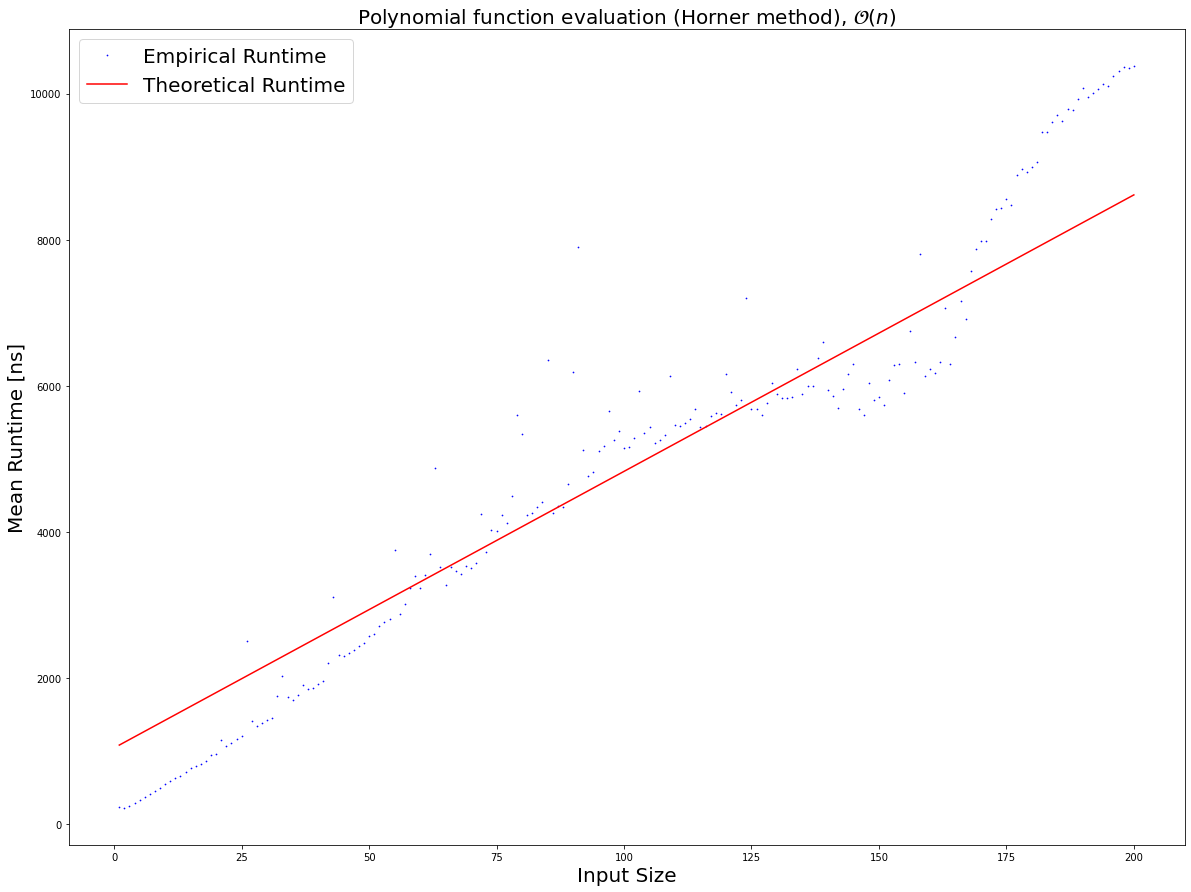

In [431]:
def calc_poly_horner(input: List[float], v=1.5) -> int:
    p = 0
    for x in reversed(input):
        p += x
        p *= v
    return p

empirical_result = run_experiment(s_inputs, calc_poly_horner)
theoretical_result = run_theoretical(s_inputs_size, empirical_result, f_type='poly', degree=1)
visualize(s_inputs_size, empirical_result, theoretical_result, r'Polynomial function evaluation (Horner method), $\mathcal{O}(n)$')

total_results.append((empirical_result, theoretical_result))

In [432]:
s_inputs_size = inputs_size[:NNN]
s_inputs = inputs[:NNN]

##  5. Bubble Sort of the elements

using proposed coeffs [ 1.83937662e+01 -1.08469045e+03  3.64256573e+04]
MSE=15543201456.46735
RMSE=124672.37647717858


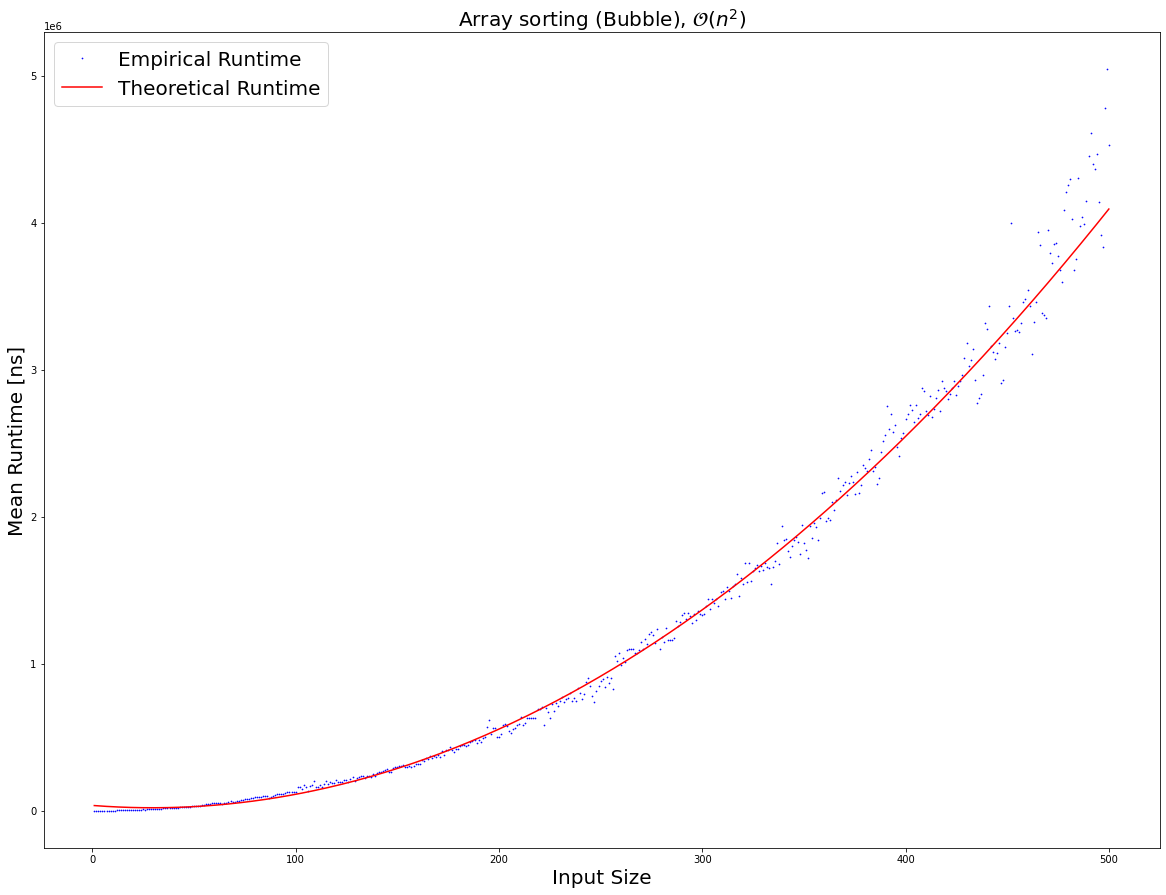

In [433]:
def sort_bubble(input: List[float]) -> List[float]:
    return sorting.bubble(input)

empirical_result = run_experiment(s_inputs, sort_bubble)
theoretical_result = run_theoretical(s_inputs_size, empirical_result, f_type='poly', degree=2)
visualize(s_inputs_size, empirical_result, theoretical_result, r'Array sorting (Bubble), $\mathcal{O}(n^2)$')

total_results.append((empirical_result, theoretical_result))

##  6. Quick Sort of the elements

using proposed coeffs [  22990.01836014 -113931.65673043 1189396.50051705]
MSE=137963651427.58203
RMSE=371434.58566426206


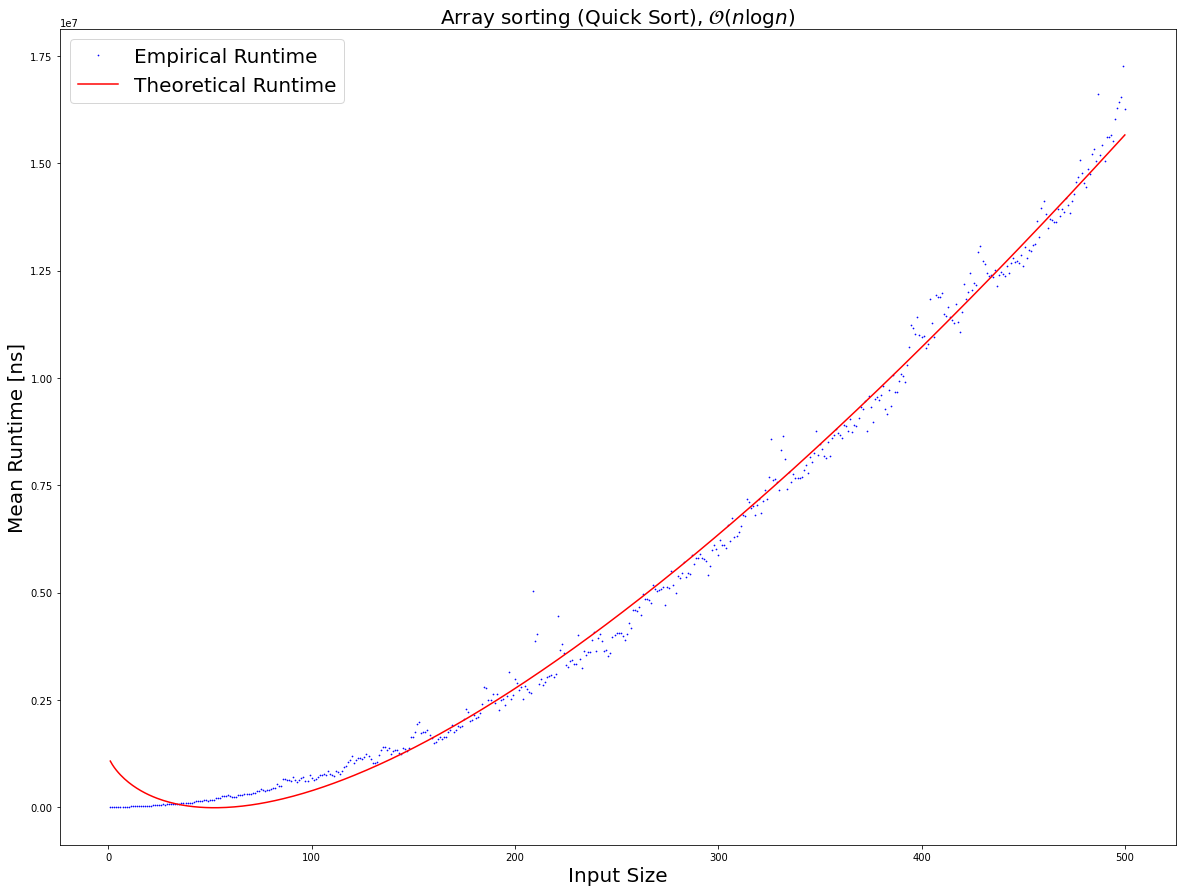

In [434]:
def sort_qsort(input: List[float]) -> List[float]:
    if len(input) == 0:
        return
    return sorting.quick(input)

empirical_result = run_experiment(s_inputs, sort_qsort)
theoretical_result = run_theoretical(s_inputs_size, empirical_result, f_type='nlogn')
visualize(s_inputs_size, empirical_result, theoretical_result, r'Array sorting (Quick Sort), $\mathcal{O}(n\log{n})$')

total_results.append((empirical_result, theoretical_result))

##  7. Timsort of the elements

using proposed coeffs [  4.49705975 -13.5480093  600.41472486]
MSE=228629.64515912157
RMSE=478.1523242222311


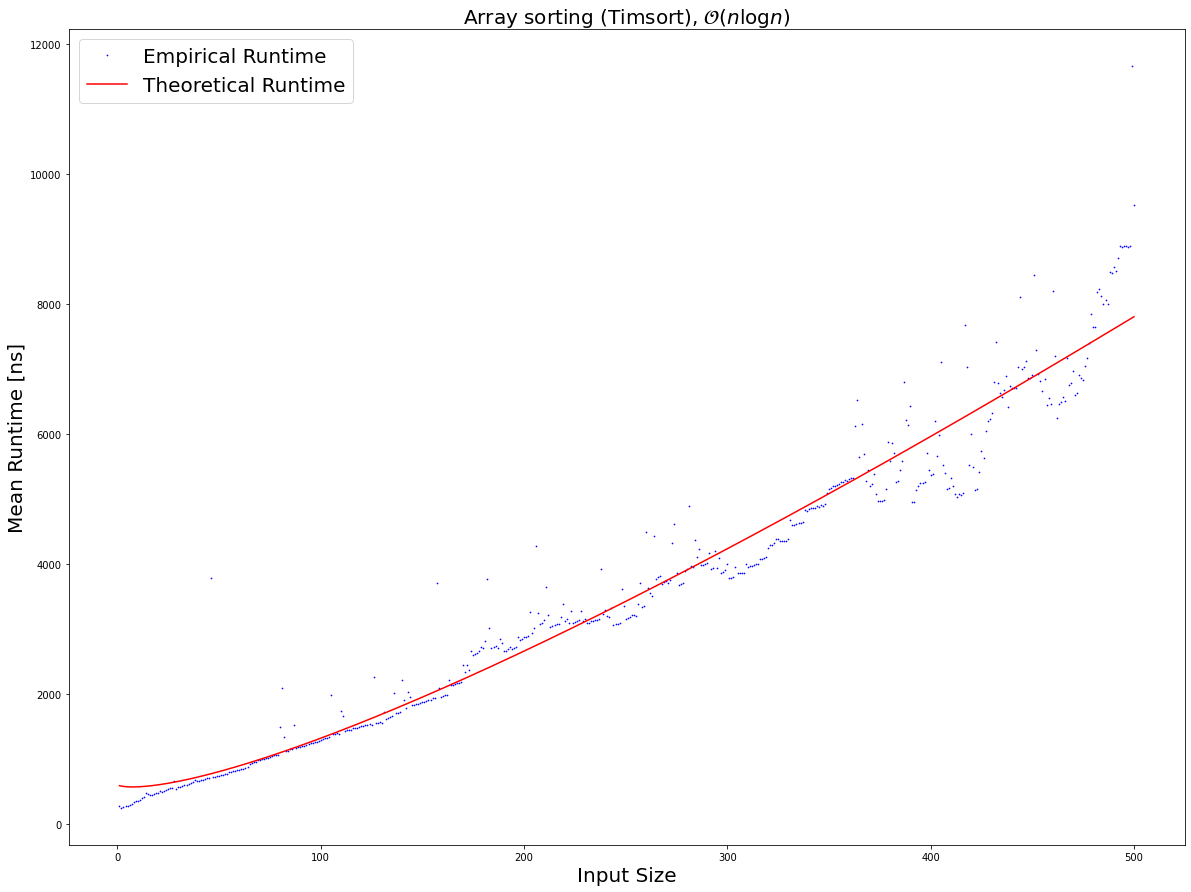

In [435]:
def sort_timsort(input: List[float]) -> List[float]:
    return sorted(input)

empirical_result = run_experiment(s_inputs, sort_timsort)
theoretical_result = run_theoretical(s_inputs_size, empirical_result, f_type='nlogn')
visualize(s_inputs_size, empirical_result, theoretical_result, r'Array sorting (Timsort), $\mathcal{O}(n\log{n})$')

total_results.append((empirical_result, theoretical_result))

# Experiment №2

In [438]:
martixs_size = [n for n in range(NN)]
martixs = [[(np.random.rand(n, n), np.random.rand(n, n))] for n in martixs_size]

using proposed coeffs [ 1.46702650e+02  1.26867438e+04 -7.06496399e+05  6.44035509e+06]
MSE=758056218819250.1
RMSE=27532820.756676026


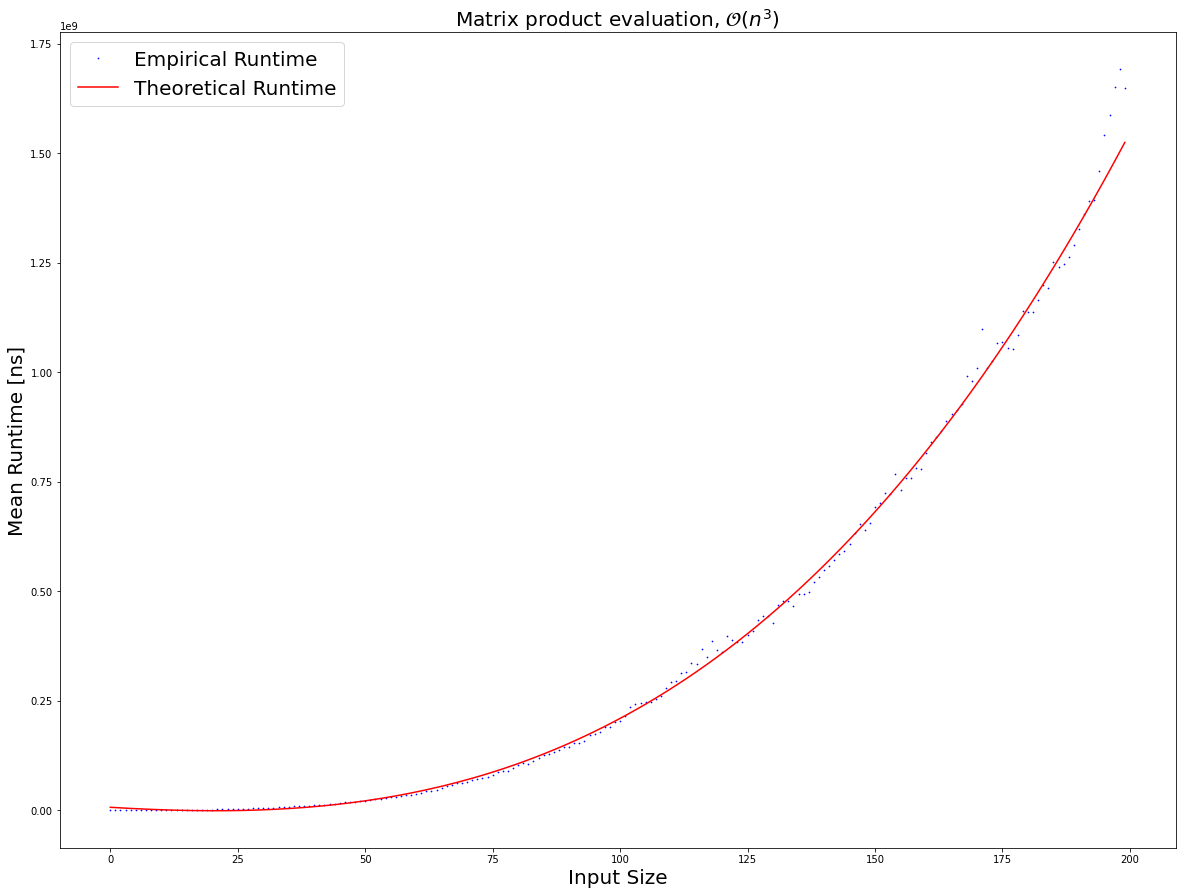

In [439]:
def calc_matrix_product(matrixs: Tuple[List[List[float]], List[List[float]]]) -> List[List[float]]:
    A, B = matrixs
    if (len(A) == 0):
        return
    result = np.zeros((len(A), len(B[0])))
    for i in range(len(A)):
        for j in range(len(B[0])):
            for k in range(len(B)):
                result[i][j] += A[i][k] * B[k][j]
    return result

empirical_result = run_experiment(martixs, calc_matrix_product)
theoretical_result = run_theoretical(martixs_size, empirical_result, f_type='poly', degree=3)
visualize(martixs_size, empirical_result, theoretical_result, r'Matrix product evaluation, $\mathcal{O}(n^3)$')

total_results.append((empirical_result, theoretical_result))